### Calculate and plot the seasonal climatology of Southern Ocean chlorophyll-a from GlobColour

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import utils.geo as geo

Note that this notebook makes use of my `utils` package, available [here](https://github.com/gmacgilchrist/utils)

## Chlorophyll

#### Load data
Preprocessing step required to assign date index to each dataset

In [79]:
rootdir = '/local/data/globcolour/merged/8-day/'
paths = glob.glob(rootdir+'*/*/*/*GSM*CHL1*.nc')
def preprocess(ds):
    time = pd.to_datetime(ds.attrs['start_time'])
    return ds.expand_dims({'time':[time]})
ds = xr.open_mfdataset(paths,preprocess=preprocess,use_cftime=False)
ds = ds.sel({'lat':slice(-40,-65)})
ds['time'] = pd.to_datetime(ds['time'].values)

#### Averaging and processing
- Take spatial average
- Interpolate onto each day of the year (necessary for taking temporal average)
- NOTE: presently extrapolating at start and end of year, where no data. Exception is for 2002 when half of the year is not covered. Could also keep these unfilled but might cause some issues in averaging. E.g. Extrapolation also looks problematic for **2021**.

In [80]:
# Get area
ds,xgrid = geo.get_xgcm_horizontal(ds,periodic='X')
ds['area'] = ds['dxC']*ds['dyC']

In [81]:
# Extract spatial average for each year
# Interpolate to each of 365 days
years = np.arange(1997,2022)
days = np.arange(1,366)
ds_year = xr.DataArray(dims=['day','year'],coords={'year':years,'day':days})
for i,year in enumerate(years):
#     print(year)
    # Need to set nans to zero otherwise it ignores them in the average!
    chl = ds['CHL1_mean'].fillna(0).weighted(ds['area'].fillna(0)).mean(['lat','lon']).sel({'time':slice(str(year)+'-01-01',str(year)+'-12-31')})
    fill_value=np.nan
    chl_allyear = chl.assign_coords({'time':chl['time.dayofyear']}).interp({'time':days},kwargs={'fill_value': fill_value})
    ds_year.loc[{'year':year}]=chl_allyear.values

#### Plot

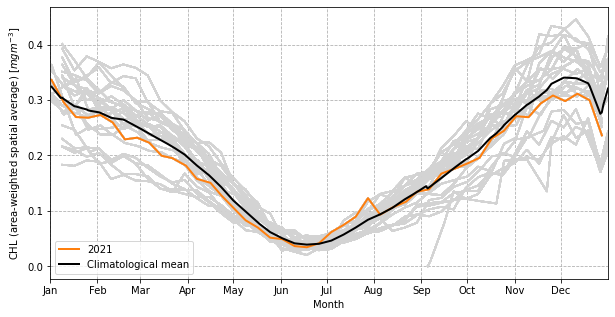

In [84]:
fig,ax = plt.subplots(figsize=(10,5))
# All years
for year in years[:-1]:
    ax.plot(ds_year['day'],ds_year,color='lightgray')
# 2021
ax.plot(ds_year['day'],ds_year.isel(year=-1),color='tab:orange',linewidth=2,label='2021')
# Climatology
ds_clim = ds_year.mean('year')
ax.plot(ds_year['day'],ds_clim,color='black',linewidth=2,label='Climatological mean')

monthname = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthlength = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
monthday = np.append(np.array([0]),np.cumsum(monthlength))
ax.set_xticks(monthday[:-1])
ax.set_xticklabels(monthname)
ax.set_xlim(0,365)
ax.set_xlabel('Month')
ax.set_ylabel('CHL (area-weighted spatial average) [$mgm^{-3}$]')
ax.grid(linestyle='--')

ax.legend()
fig.savefig('../../figures/seasonal-climatology_globcolour_CHL.png',dpi=300,transparent=True)

## POC

In [75]:
def preprocess(ds):
    time = pd.to_datetime(ds.attrs['start_time'])
    return ds.expand_dims({'time':[time]})
rootdir = '/local/data/globcolour/merged/8-day/'
# Straight averages
paths = glob.glob(rootdir+'*/*/*/*_AV-*POC_8D_00.nc')
ds = xr.open_mfdataset(paths,preprocess=preprocess,use_cftime=False)
ds = ds.sel({'lat':slice(-40,-65)})
ds['time'] = pd.to_datetime(ds['time'].values)
# Weighted averages
pathsW = glob.glob(rootdir+'*/*/*/*_AVW-*POC_8D_00.nc')
dsW = xr.open_mfdataset(pathsW,preprocess=preprocess,use_cftime=False)
dsW = dsW.sel({'lat':slice(-40,-65)})
dsW['time'] = pd.to_datetime(dsW['time'].values)
# Merge datasets (takes some time) and reset chunks
ds = xr.merge([ds,dsW]).chunk({'time':1})

In [76]:
# Get area
ds,xgrid = geo.get_xgcm_horizontal(ds,periodic='X')
ds['area'] = ds['dxC']*ds['dyC']

In [77]:
# Extract spatial average for each year
# Interpolate to each of 365 days
years = np.arange(1997,2022)
days = np.arange(1,366)
ds_year = xr.DataArray(dims=['day','year'],coords={'year':years,'day':days})
for i,year in enumerate(years):
#     print(year)
    # Need to set nans to zero otherwise it ignores them in the average!
    poc = ds['POC_mean'].fillna(0).weighted(ds['area'].fillna(0)).mean(['lat','lon']).sel({'time':slice(str(year)+'-01-01',str(year)+'-12-31')})
    fill_value=np.nan
    poc_allyear = poc.assign_coords({'time':poc['time.dayofyear']}).interp({'time':days},kwargs={'fill_value': fill_value})
    ds_year.loc[{'year':year}]=poc_allyear.values

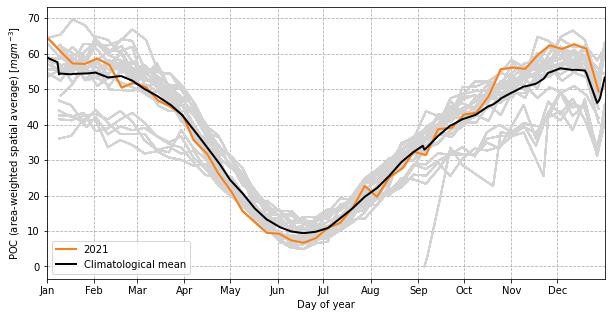

In [78]:
fig,ax = plt.subplots(figsize=(10,5))
# All years
for year in years[:-1]:
    ax.plot(ds_year['day'],ds_year,color='lightgray')
# 2021
ax.plot(ds_year['day'],ds_year.isel(year=-1),color='tab:orange',linewidth=2,label='2021')
# Climatology
ds_clim = ds_year.mean('year')
ax.plot(ds_year['day'],ds_clim,color='black',linewidth=2,label='Climatological mean')

monthname = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthlength = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
monthday = np.append(np.array([0]),np.cumsum(monthlength))
ax.set_xticks(monthday[:-1])
ax.set_xticklabels(monthname)
ax.set_xlim(0,365)
ax.set_xlabel('Month')
ax.set_ylabel('POC (area-weighted spatial average) [$mgm^{-3}$]')
ax.grid(linestyle='--')

ax.legend()
fig.savefig('../../figures/seasonal-climatology_globcolour_POC.png',dpi=300,transparent=True)

### Spatial maps

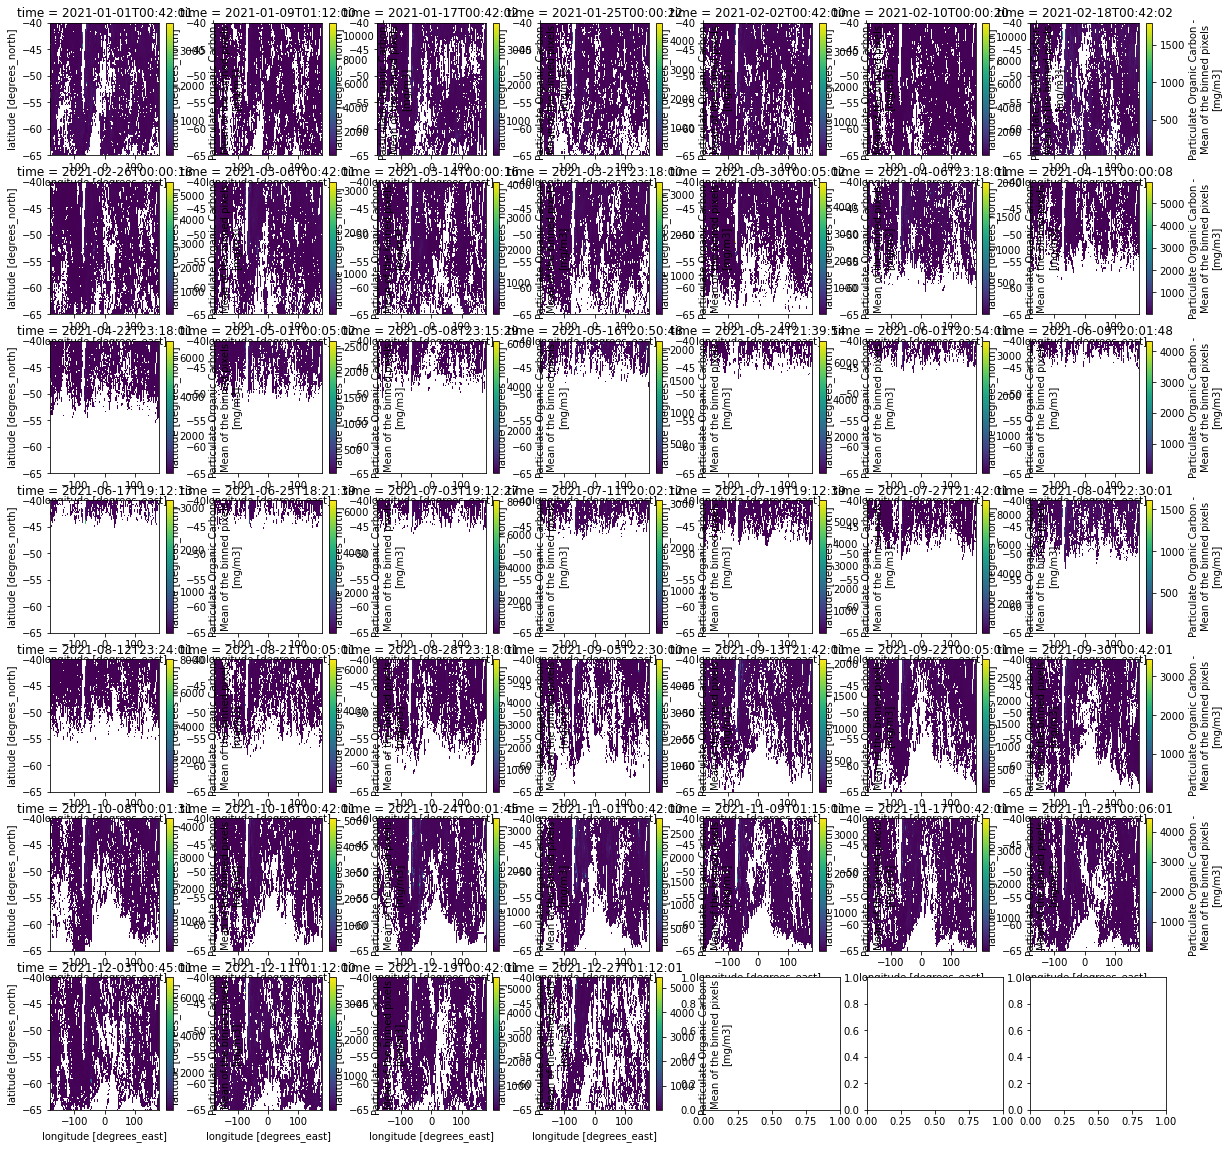

In [70]:
nt = len(ds2021['time'])
fig,axarr=plt.subplots(figsize=(20,20),ncols=round(np.sqrt(nt)),nrows=round(np.sqrt(nt)))
for i in range(nt):
    ax = axarr.flat[i]
    ds2021['POC_mean'].isel(time=i).plot(ax=ax)

368

In [ ]:
# pathsW = glob.glob(rootdir+'*/*/*/*_AVW-*POC_8D_00.nc')
paths = glob.glob(rootdir+'*/*/*/*_AV-*POC_8D_00.nc')
ds = xr.open_dataset(paths[0])
dsW = xr.open_dataset(pathsW[0])

In [31]:
ds['lon']

<xarray.DataArray 'lon' (lon: 1440)>
array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    long_name:  longitude
    units:      degrees_east
    axis:       X

In [32]:
dsW['lon']

<xarray.DataArray 'lon' (lon: 1440)>
array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    long_name:  longitude
    units:      degrees_east
    axis:       X